# Part 1: Using Data Science to Understand What Makes Wine Taste Good

This notebook will showcase [RandomForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to perform a multi-class classifier on the quality of wines, and compare it with other algorithms such as Decision Tree and GuassianNB.


### Section 1: Data Exploration

In this section, we'll do some exploratory analysis to understand the nature of our data and the underlying distribution.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for displaying DataFrames

import matplotlib.pyplot as plt
import seaborn as sns

# Import supplementary visualization code visuals.py from project root folder
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

##### Usage of these libraries:
* [numpy](http://www.numpy.org/) is a package in python that is used for scientific computing. It supports higher-order mathematical functions, higher dimensional arrays, matrices and other data structures.
* [pandas](https://pandas.pydata.org/) is a very popular library that is used for a lot of data analysis and statistics related problems.
* [time](https://docs.python.org/3.7/library/time.html) - standard module in python that allows for time related functions
* [display](http://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html?highlight=display) is a module in the IPython toolkit that helps you display data structures in a nice, readable format.
* [matplotlib](https://matplotlib.org/) is a very popular visualization library that lets you create a wide array of figures, charts and graphs in the IPython Notebook
* [seaborn](https://seaborn.pydata.org/index.html) is another visualization tool that uses matplotlib underneath, and provides you with easy-to-use APIs for visualization. It also makes your graphs more prettier!

#### Load the dataset for red wines, and display the first 5 columns

In [2]:
# Load the Red Wines dataset
data = pd.read_csv("data/winequality-red.csv", sep=';')

display(data.head(n=5))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


#### Preliminary analysis

In [3]:
# Find if the data has any null information
data.isnull().any()

fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool

In [4]:
#Get additional information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


The last column *quality* is a metric of how good a specific wine was rated to be. 
For our purposes, let's consider wines:
 - with ratings 7 and above to be of very good quality
 - with 5 and 6 to be of average quality
 - less than 5 to be of insipid quality.

In [5]:
# Total number of wines
n_wines = data.shape[0]

# Number of wines with quality rating above 6
quality_above_6 = data.loc[(data['quality'] > 6)]
n_above_6 = quality_above_6.shape[0]

# Number of wines with quality rating below 5
quality_below_5 = data.loc[(data['quality'] < 5)]
n_below_5 = quality_below_5.shape[0]

# Number of wines with quality rating between 5 to 6
quality_between_5 = data.loc[(data['quality']) >= 5 & (data['quality'] <= 6)]
n_between_5 = quality_between_5.shape[0]

# Percentage of wines with quality rating above 6
greater_percent = n_above_6*100/n_wines

# Print the results
print("Total number of wine data: {}".format(n_wines))
print("Wines with rating 7 and above: {}".format(n_above_6))
print("Wines with rating less than 5: {}".format(n_below_5))
print("Wines with rating 5 and 6: {}".format(n_between_5))
print("Percentage of wines with quality 7 and above: {:.2f}%".format(greater_percent))


Total number of wine data: 1599
Wines with rating 7 and above: 217
Wines with rating less than 5: 63
Wines with rating 5 and 6: 1599
Percentage of wines with quality 7 and above: 13.57%


#### Data Distribution of the Wine Quality

/Users/exu364/Git/machine-learning/misc/game_of_wines/visuals.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


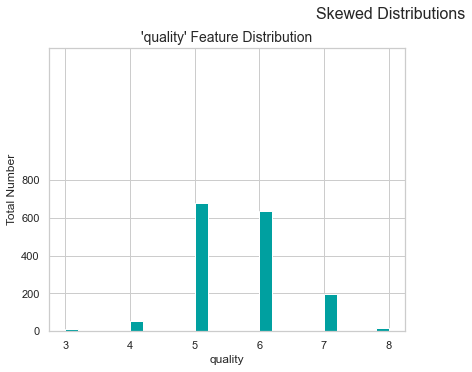

In [6]:
# Visualize skewed continuous features of original data
vs.distribution(data, "quality")

#### Get useful statistics, such as mean, median and standard deviation of the features:

In [7]:
# Get some additional statistics, like mean, median and standard deviation
display(np.round(data.describe()))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.0,1599.0,1599.0,1599.0,1599.0,1599.0,1599.0,1599.0,1599.0,1599.0,1599.0,1599.0
mean,8.0,1.0,0.0,3.0,0.0,16.0,46.0,1.0,3.0,1.0,10.0,6.0
std,2.0,0.0,0.0,1.0,0.0,10.0,33.0,0.0,0.0,0.0,1.0,1.0
min,5.0,0.0,0.0,1.0,0.0,1.0,6.0,1.0,3.0,0.0,8.0,3.0
25%,7.0,0.0,0.0,2.0,0.0,7.0,22.0,1.0,3.0,1.0,10.0,5.0
50%,8.0,1.0,0.0,2.0,0.0,14.0,38.0,1.0,3.0,1.0,10.0,6.0
75%,9.0,1.0,0.0,3.0,0.0,21.0,62.0,1.0,3.0,1.0,11.0,6.0
max,16.0,2.0,1.0,16.0,1.0,72.0,289.0,1.0,4.0,2.0,15.0,8.0


As we can see, most fines fall under **average quality (between 5 and 6)**. Wines which were rated high are in the lower hundreds, whereas there are very few wines that aren't tasty enough (low ratings).

Next, since our aim is to predict the quality of wines, we’ll now extract the last column and store it separately.

### Section 2: Exploring Relationships between features

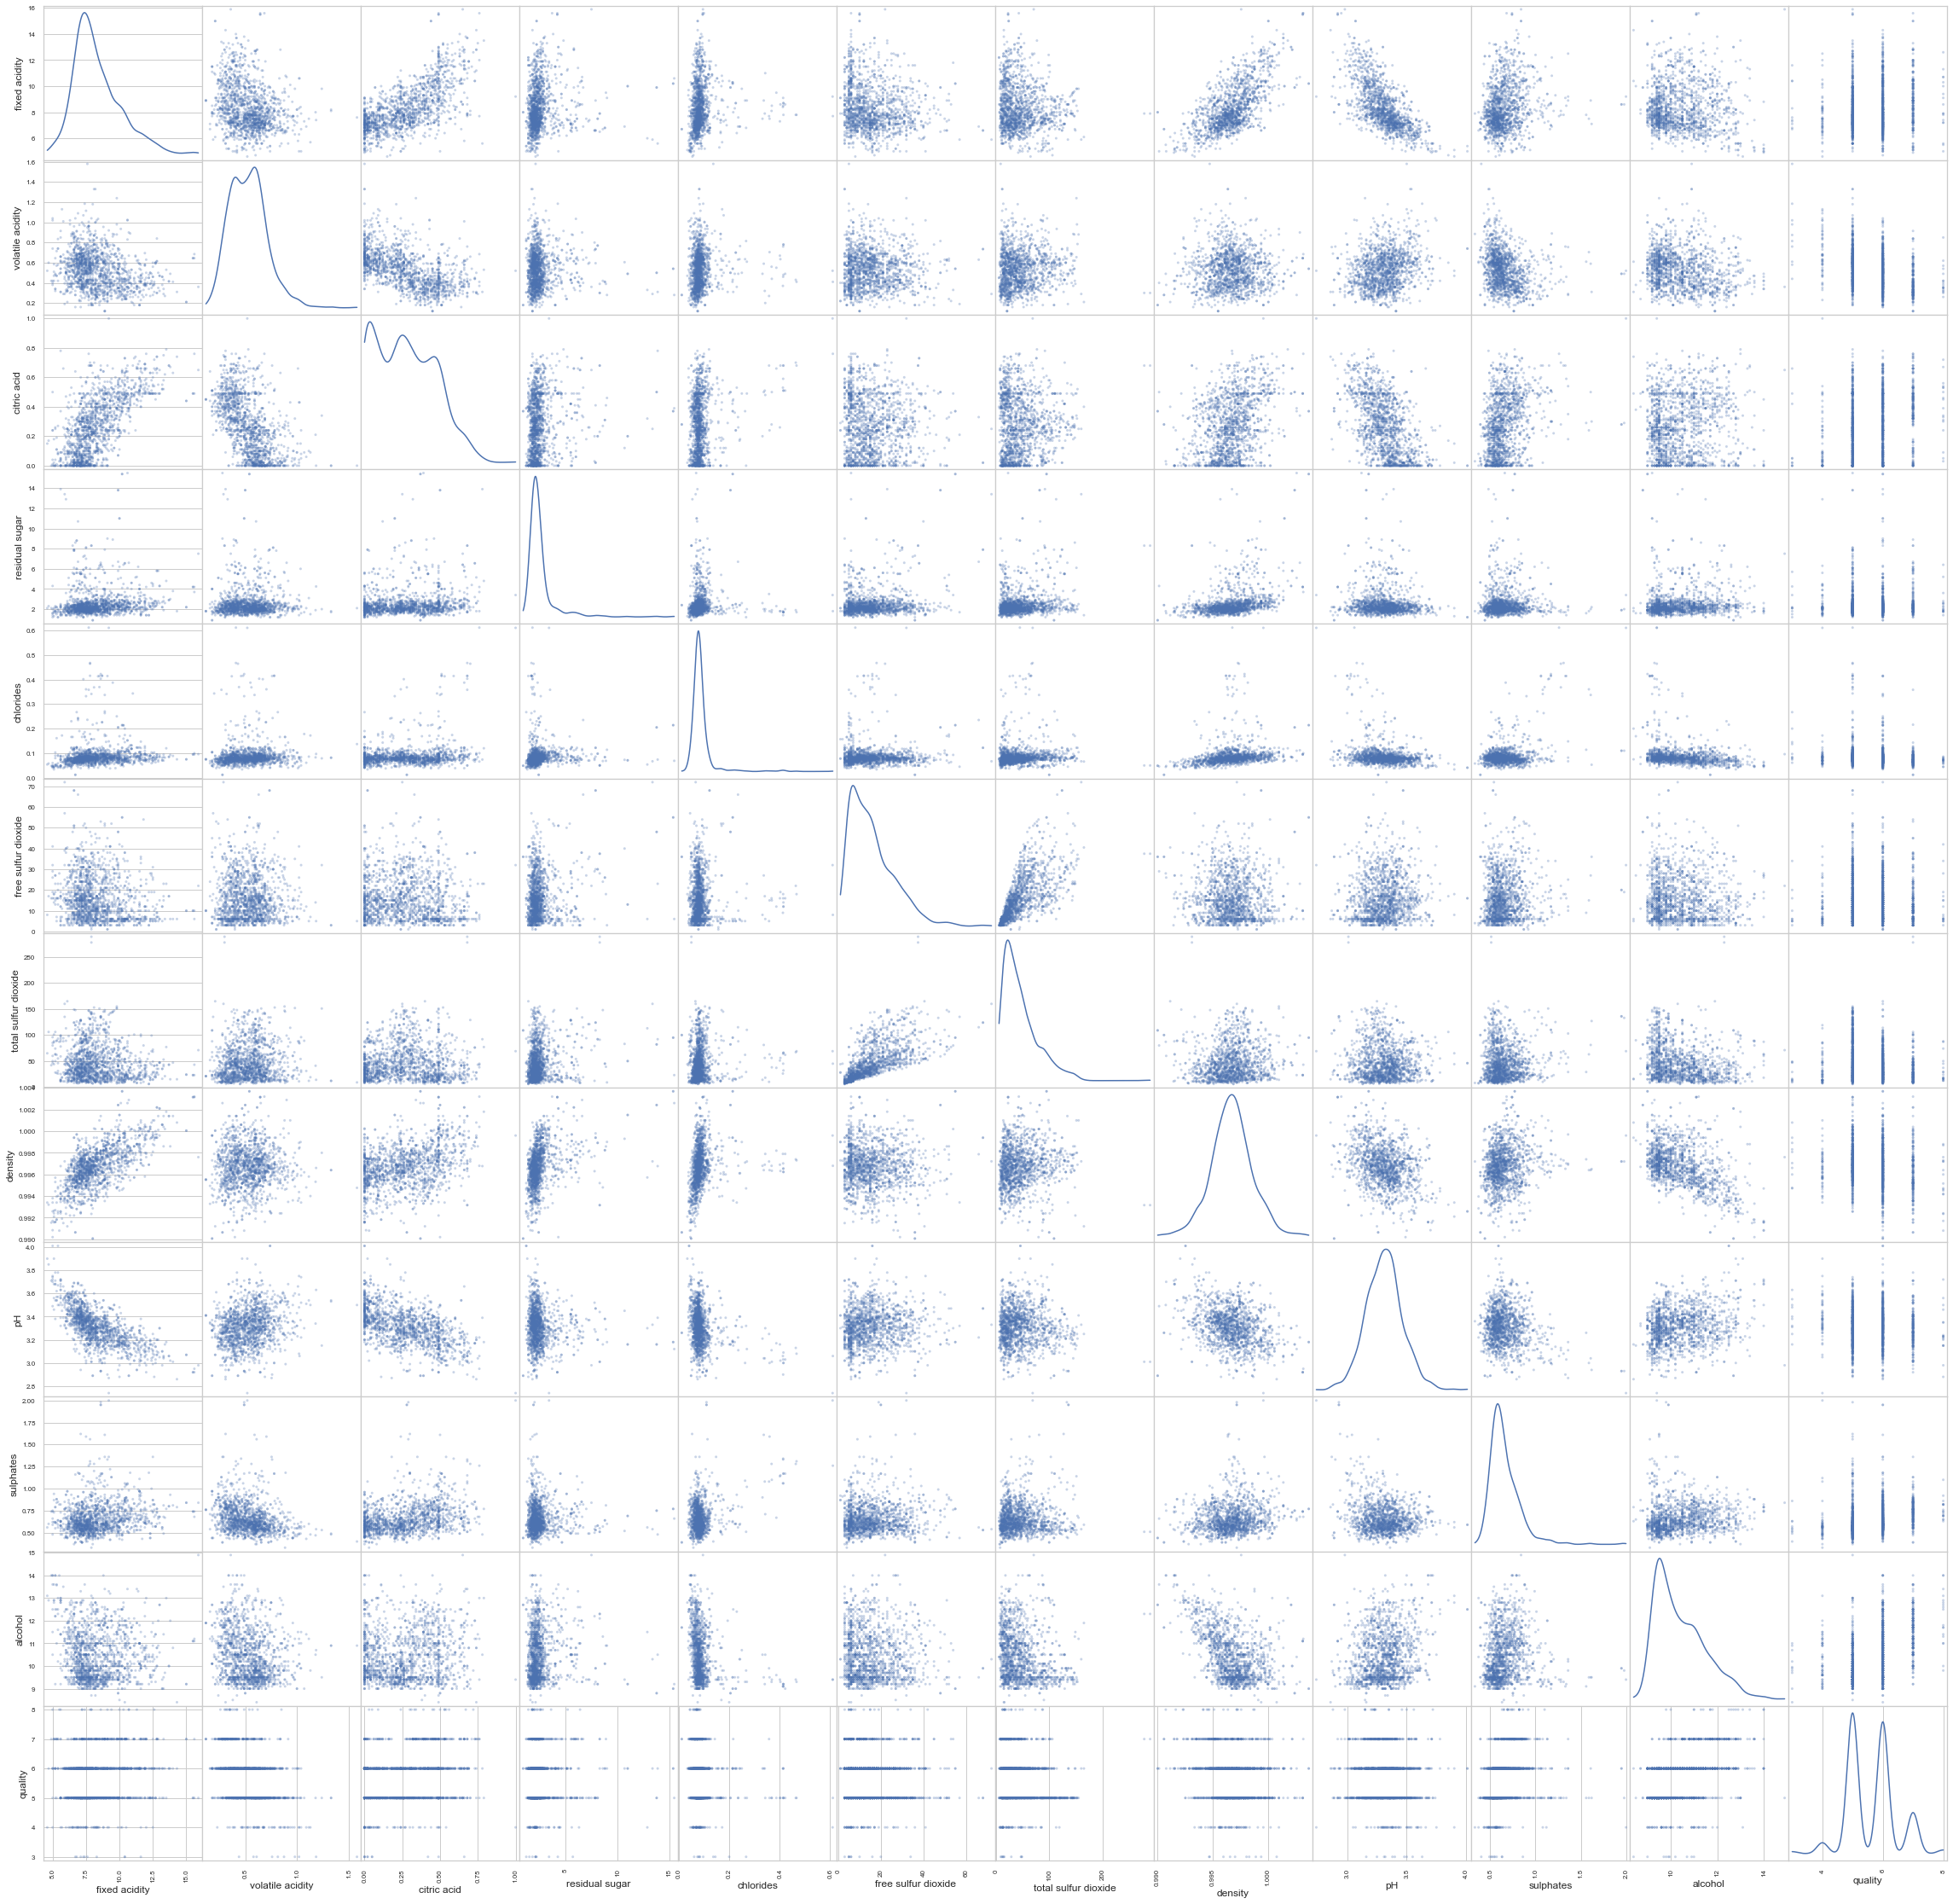

In [8]:
# Draw a scatter-plot of features
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (40,40), diagonal = 'kde');


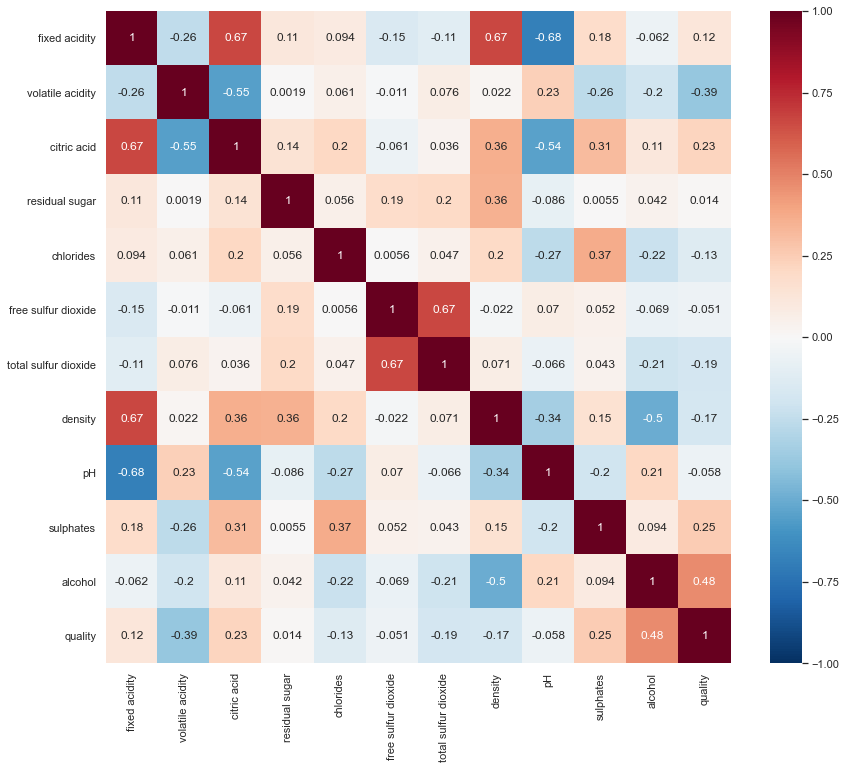

In [9]:
# Draw a heatmap between features
correlation = data.corr()
#display(correlation)
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

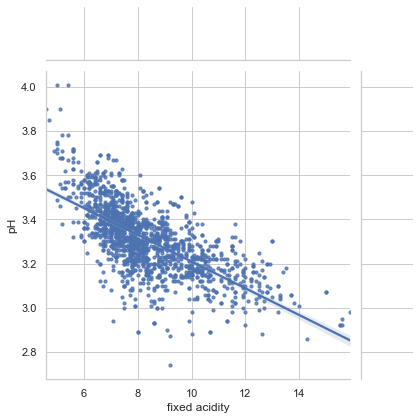

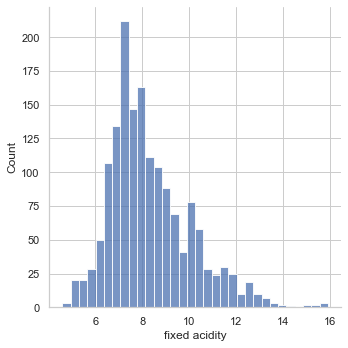

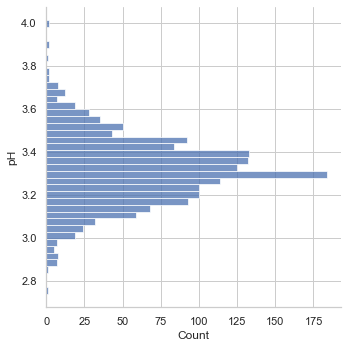

In [11]:
# Visualize the co-relation between pH and fixed Acidity

# Create a new dataframe containing only pH and fixed acidity columns to visualize their co-relations
fixedAcidity_pH = data[['pH', 'fixed acidity']]

# Initialize a joint-grid with the dataframe, using seaborn library
gridA = sns.JointGrid(x="fixed acidity", y="pH", data=fixedAcidity_pH, height=6)

# Draws a regression plot in the grid 
gridA = gridA.plot_joint(sns.regplot, scatter_kws={"s": 10})

# Draws a distribution plot in the same grid
gridA = gridA.plot_marginals(sns.displot)


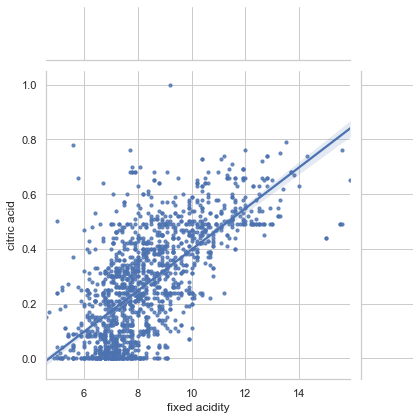

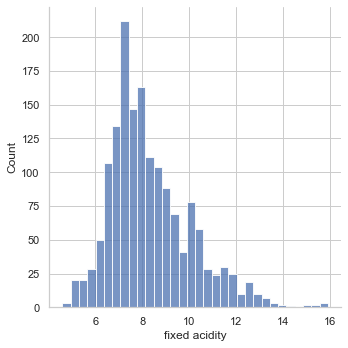

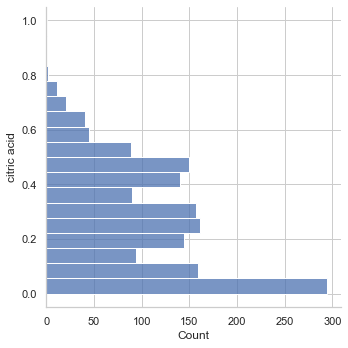

In [12]:
# Visualize a plot between Citric Acid levels and Fixed Acidity
fixedAcidity_citricAcid = data[['citric acid', 'fixed acidity']]
g = sns.JointGrid(x="fixed acidity", y="citric acid", data=fixedAcidity_citricAcid, height=6)
g = g.plot_joint(sns.regplot, scatter_kws={"s": 10})
g = g.plot_marginals(sns.displot)

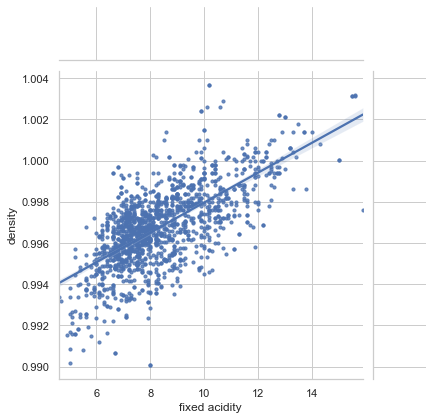

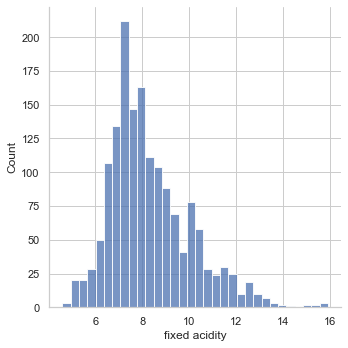

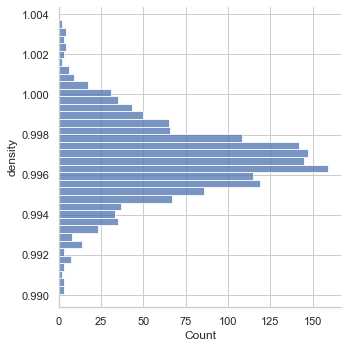

In [13]:
# Visualize density vs fixed acidity
fixedAcidity_density = data[['density', 'fixed acidity']]
gridB = sns.JointGrid(x="fixed acidity", y="density", data=fixedAcidity_density, height=6)
gridB = gridB.plot_joint(sns.regplot, scatter_kws={"s": 10})
gridB = gridB.plot_marginals(sns.displot)

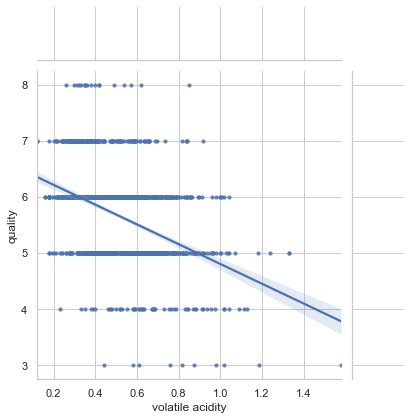

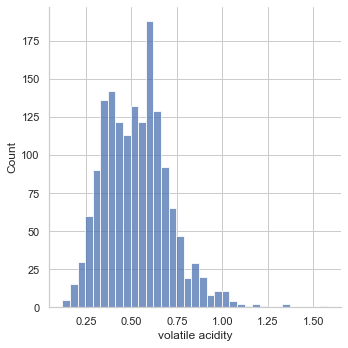

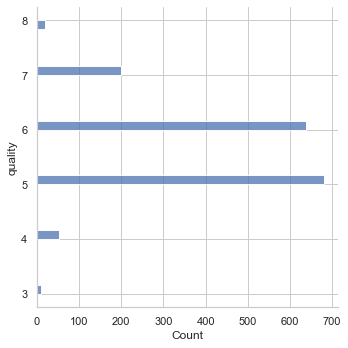

In [14]:
# Visualize quality vs volatile acidity
volatileAcidity_quality = data[['quality', 'volatile acidity']]
g = sns.JointGrid(x="volatile acidity", y="quality", data=volatileAcidity_quality, height=6)
g = g.plot_joint(sns.regplot, scatter_kws={"s": 10})
g = g.plot_marginals(sns.displot)

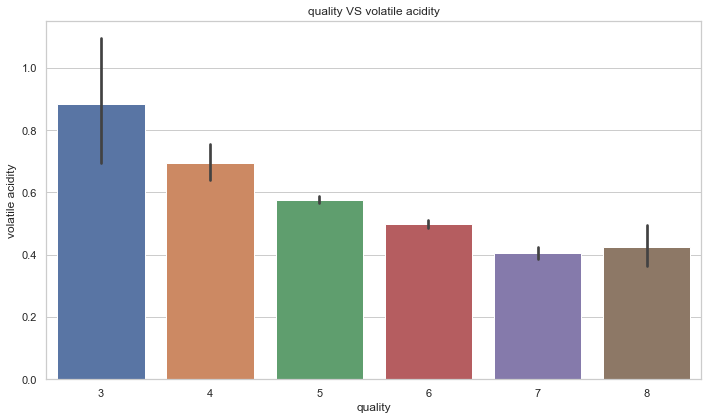

<Figure size 432x288 with 0 Axes>

In [15]:
# We can visualize relationships of discreet values (quality vs volatile acidity) better with a bar plot

fig, axs = plt.subplots(ncols=1,figsize=(10,6))
sns.barplot(x='quality', y='volatile acidity', data=volatileAcidity_quality, ax=axs)
plt.title('quality VS volatile acidity')

plt.tight_layout()
plt.show()
plt.gcf().clear()

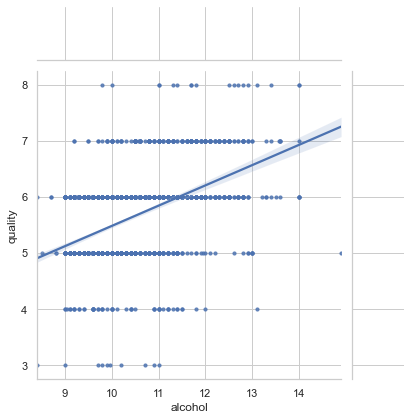

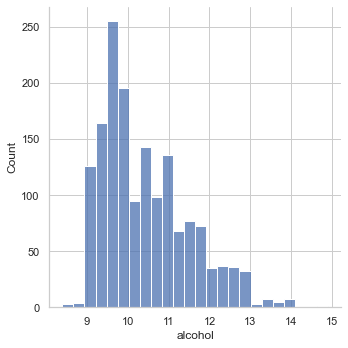

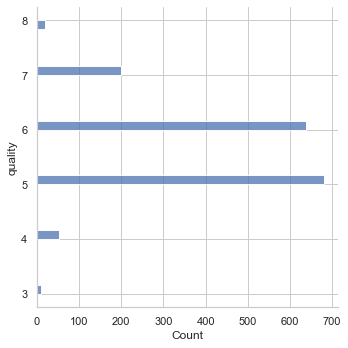

In [17]:
quality_alcohol = data[['alcohol', 'quality']]

g = sns.JointGrid(x="alcohol", y="quality", data=quality_alcohol, height=6)
g = g.plot_joint(sns.regplot, scatter_kws={"s": 10})
g = g.plot_marginals(sns.displot)

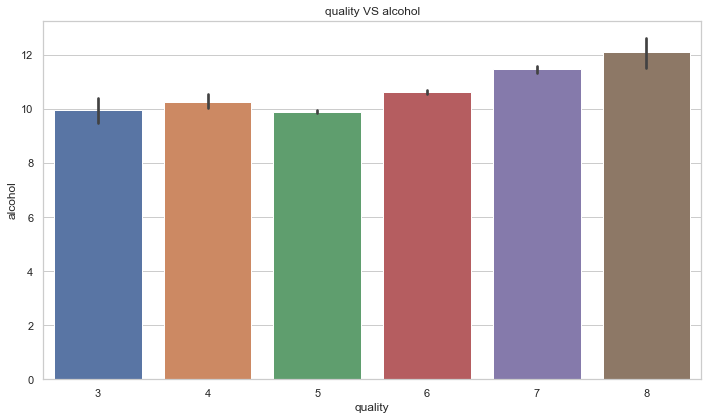

<Figure size 432x288 with 0 Axes>

In [18]:
# Visualize quality vs alcohol with a bar plot
fig, axs = plt.subplots(ncols=1,figsize=(10,6))
sns.barplot(x='quality', y='alcohol', data=quality_alcohol, ax=axs)
plt.title('quality VS alcohol')

plt.tight_layout()
plt.show()
plt.gcf().clear()

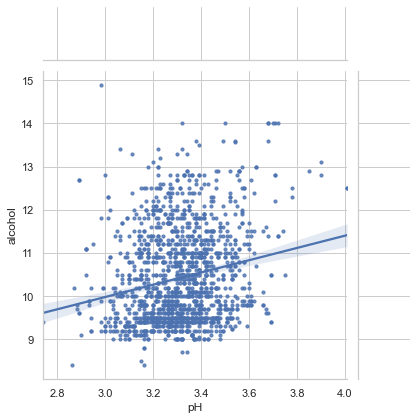

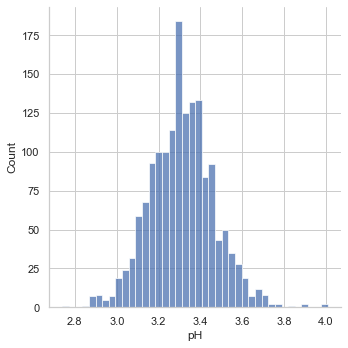

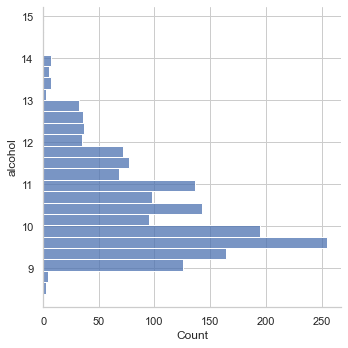

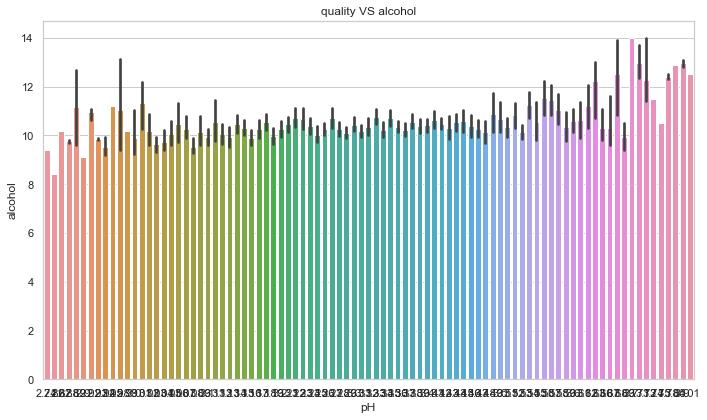

<Figure size 432x288 with 0 Axes>

In [22]:
# Selecting any two features and view their relationship
featureA = 'pH'
featureB = 'alcohol'
featureA_featureB = data[[featureA, featureB]]

g = sns.JointGrid(x=featureA, y=featureB, data=featureA_featureB, height=6)
g = g.plot_joint(sns.regplot, scatter_kws={"s": 10})
g = g.plot_marginals(sns.displot)

fig, axs = plt.subplots(ncols=1,figsize=(10,6))
sns.barplot(x=featureA, y=featureB, data=featureA_featureB, ax=axs)
plt.title('quality VS alcohol')

plt.tight_layout()
plt.show()
plt.gcf().clear()

#### Outlier Detection:

Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An **outlier step** is calculated as **1.5** times the **interquartile range (IQR)**. A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below:

* Assign the value of the 25th percentile for the given feature to Q1. Use np.percentile for this.
* Assign the value of the 75th percentile for the given feature to Q3. Again, use np.percentile.
* Assign the calculation of an outlier step for the given feature to step.
* Optionally remove data points from the dataset by adding indices to the outliers list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!
Once you have performed this implementation, the dataset will be stored in the variable good_data.

In [23]:
# Find outliers for each feature

# For each feature find the data points with extreme high or low values
for feature in data.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(data[feature], q=25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(data[feature], q=75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    interquartile_range = Q3 - Q1
    step = 1.5 * interquartile_range
    
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(data[~((data[feature] >= Q1 - step) & (data[feature] <= Q3 + step))])
    
# OPTIONAL: Select the indices for data points you wish to remove
outliers  = []

# Remove the outliers, if any were specified
good_data = data.drop(data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'fixed acidity':


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
205,12.8,0.300,0.74,2.6,0.095,9.0,28.0,0.99940,3.20,0.77,10.8,7
206,12.8,0.300,0.74,2.6,0.095,9.0,28.0,0.99940,3.20,0.77,10.8,7
243,15.0,0.210,0.44,2.2,0.075,10.0,24.0,1.00005,3.07,0.84,9.2,7
244,15.0,0.210,0.44,2.2,0.075,10.0,24.0,1.00005,3.07,0.84,9.2,7
264,12.5,0.560,0.49,2.4,0.064,5.0,27.0,0.99990,3.08,0.87,10.9,5
294,13.3,0.340,0.52,3.2,0.094,17.0,53.0,1.00140,3.05,0.81,9.5,6
328,13.4,0.270,0.62,2.6,0.082,6.0,21.0,1.00020,3.16,0.67,9.7,6
338,12.4,0.490,0.58,3.0,0.103,28.0,99.0,1.00080,3.16,1.00,11.5,6
339,12.5,0.280,0.54,2.3,0.082,12.0,29.0,0.99970,3.11,1.36,9.8,7
347,13.8,0.490,0.67,3.0,0.093,6.0,15.0,0.99860,3.02,0.93,12.0,6


Data points considered outliers for the feature 'volatile acidity':


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
38,5.7,1.130,0.09,1.50,0.172,7.0,19.0,0.99400,3.50,0.48,9.8,4
94,5.0,1.020,0.04,1.40,0.045,41.0,85.0,0.99380,3.75,0.48,10.5,4
120,7.3,1.070,0.09,1.70,0.178,10.0,89.0,0.99620,3.30,0.57,9.0,5
126,8.2,1.330,0.00,1.70,0.081,3.0,12.0,0.99640,3.53,0.49,10.9,5
127,8.1,1.330,0.00,1.80,0.082,3.0,12.0,0.99640,3.54,0.48,10.9,5
134,7.9,1.040,0.05,2.20,0.084,13.0,29.0,0.99590,3.22,0.55,9.9,6
199,6.9,1.090,0.06,2.10,0.061,12.0,31.0,0.99480,3.51,0.43,11.4,4
553,5.0,1.040,0.24,1.60,0.050,32.0,96.0,0.99340,3.74,0.62,11.5,5
672,9.8,1.240,0.34,2.00,0.079,32.0,151.0,0.99800,3.15,0.53,9.5,5
690,7.4,1.185,0.00,4.25,0.097,5.0,14.0,0.99660,3.63,0.54,10.7,3


Data points considered outliers for the feature 'citric acid':


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
151,9.2,0.52,1.0,3.4,0.61,32.0,69.0,0.9996,2.74,2.0,9.4,4


Data points considered outliers for the feature 'residual sugar':


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
9,7.5,0.500,0.36,6.1,0.071,17.0,102.0,0.99780,3.35,0.80,10.5,5
11,7.5,0.500,0.36,6.1,0.071,17.0,102.0,0.99780,3.35,0.80,10.5,5
14,8.9,0.620,0.18,3.8,0.176,52.0,145.0,0.99860,3.16,0.88,9.2,5
15,8.9,0.620,0.19,3.9,0.170,51.0,148.0,0.99860,3.17,0.93,9.2,5
18,7.4,0.590,0.08,4.4,0.086,6.0,29.0,0.99740,3.38,0.50,9.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
1552,6.3,0.680,0.01,3.7,0.103,32.0,54.0,0.99586,3.51,0.66,11.3,6
1558,6.9,0.630,0.33,6.7,0.235,66.0,115.0,0.99787,3.22,0.56,9.5,5
1574,5.6,0.310,0.78,13.9,0.074,23.0,92.0,0.99677,3.39,0.48,10.5,6
1577,6.2,0.700,0.15,5.1,0.076,13.0,27.0,0.99622,3.54,0.60,11.9,6


Data points considered outliers for the feature 'chlorides':


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
14,8.9,0.62,0.18,3.8,0.176,52.0,145.0,0.99860,3.16,0.88,9.2,5
15,8.9,0.62,0.19,3.9,0.170,51.0,148.0,0.99860,3.17,0.93,9.2,5
17,8.1,0.56,0.28,1.7,0.368,16.0,56.0,0.99680,3.11,1.28,9.3,5
19,7.9,0.32,0.51,1.8,0.341,17.0,56.0,0.99690,3.04,1.08,9.2,6
38,5.7,1.13,0.09,1.5,0.172,7.0,19.0,0.99400,3.50,0.48,9.8,4
...,...,...,...,...,...,...,...,...,...,...,...,...
1476,9.9,0.50,0.50,13.8,0.205,48.0,82.0,1.00242,3.16,0.75,8.8,5
1490,7.1,0.22,0.49,1.8,0.039,8.0,18.0,0.99344,3.39,0.56,12.4,6
1558,6.9,0.63,0.33,6.7,0.235,66.0,115.0,0.99787,3.22,0.56,9.5,5
1570,6.4,0.36,0.53,2.2,0.230,19.0,35.0,0.99340,3.37,0.93,12.4,6


Data points considered outliers for the feature 'free sulfur dioxide':


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
14,8.9,0.620,0.18,3.80,0.176,52.0,145.0,0.99860,3.16,0.88,9.2,5
15,8.9,0.620,0.19,3.90,0.170,51.0,148.0,0.99860,3.17,0.93,9.2,5
57,7.5,0.630,0.12,5.10,0.111,50.0,110.0,0.99830,3.26,0.77,9.4,5
396,6.6,0.735,0.02,7.90,0.122,68.0,124.0,0.99940,3.47,0.53,9.9,5
400,6.6,0.735,0.02,7.90,0.122,68.0,124.0,0.99940,3.47,0.53,9.9,5
497,7.2,0.340,0.32,2.50,0.090,43.0,113.0,0.99660,3.32,0.79,11.1,5
522,8.2,0.390,0.49,2.30,0.099,47.0,133.0,0.99790,3.38,0.99,9.8,5
584,11.8,0.330,0.49,3.40,0.093,54.0,80.0,1.00020,3.30,0.76,10.7,7
634,7.9,0.350,0.21,1.90,0.073,46.0,102.0,0.99640,3.27,0.58,9.5,5
678,8.3,0.780,0.10,2.60,0.081,45.0,87.0,0.99830,3.48,0.53,10.0,5


Data points considered outliers for the feature 'total sulfur dioxide':


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
14,8.9,0.620,0.18,3.8,0.176,52.0,145.0,0.99860,3.16,0.88,9.2,5
15,8.9,0.620,0.19,3.9,0.170,51.0,148.0,0.99860,3.17,0.93,9.2,5
86,8.6,0.490,0.28,1.9,0.110,20.0,136.0,0.99720,2.93,1.95,9.9,6
88,9.3,0.390,0.44,2.1,0.107,34.0,125.0,0.99780,3.14,1.22,9.5,5
90,7.9,0.520,0.26,1.9,0.079,42.0,140.0,0.99640,3.23,0.54,9.5,5
91,8.6,0.490,0.28,1.9,0.110,20.0,136.0,0.99720,2.93,1.95,9.9,6
92,8.6,0.490,0.29,2.0,0.110,19.0,133.0,0.99720,2.93,1.98,9.8,5
109,8.1,0.785,0.52,2.0,0.122,37.0,153.0,0.99690,3.21,0.69,9.3,5
130,8.0,0.745,0.56,2.0,0.118,30.0,134.0,0.99680,3.24,0.66,9.4,5
145,8.1,0.670,0.55,1.8,0.117,32.0,141.0,0.99680,3.17,0.62,9.4,5


Data points considered outliers for the feature 'density':


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
142,5.2,0.340,0.00,1.80,0.050,27.0,63.0,0.99160,3.68,0.79,14.000000,6
144,5.2,0.340,0.00,1.80,0.050,27.0,63.0,0.99160,3.68,0.79,14.000000,6
294,13.3,0.340,0.52,3.20,0.094,17.0,53.0,1.00140,3.05,0.81,9.500000,6
324,10.0,0.490,0.20,11.00,0.071,13.0,50.0,1.00150,3.16,0.69,9.200000,6
325,10.0,0.490,0.20,11.00,0.071,13.0,50.0,1.00150,3.16,0.69,9.200000,6
353,13.5,0.530,0.79,4.80,0.120,23.0,77.0,1.00180,3.18,0.77,13.000000,5
354,6.1,0.210,0.40,1.40,0.066,40.5,165.0,0.99120,3.25,0.59,11.900000,6
364,12.8,0.615,0.66,5.80,0.083,7.0,42.0,1.00220,3.07,0.73,10.000000,7
366,12.8,0.615,0.66,5.80,0.083,7.0,42.0,1.00220,3.07,0.73,10.000000,7
374,14.0,0.410,0.63,3.80,0.089,6.0,47.0,1.00140,3.01,0.81,10.800000,6


Data points considered outliers for the feature 'pH':


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
45,4.6,0.520,0.15,2.10,0.054,8.0,65.0,0.99340,3.90,0.56,13.1,4
94,5.0,1.020,0.04,1.40,0.045,41.0,85.0,0.99380,3.75,0.48,10.5,4
95,4.7,0.600,0.17,2.30,0.058,17.0,106.0,0.99320,3.85,0.60,12.9,6
151,9.2,0.520,1.00,3.40,0.610,32.0,69.0,0.99960,2.74,2.00,9.4,4
268,6.9,0.540,0.04,3.00,0.077,7.0,27.0,0.99870,3.69,0.91,9.4,6
276,6.9,0.540,0.04,3.00,0.077,7.0,27.0,0.99870,3.69,0.91,9.4,6
440,12.6,0.310,0.72,2.20,0.072,6.0,29.0,0.99870,2.88,0.82,9.8,8
544,14.3,0.310,0.74,1.80,0.075,6.0,15.0,1.00080,2.86,0.79,8.4,6
553,5.0,1.040,0.24,1.60,0.050,32.0,96.0,0.99340,3.74,0.62,11.5,5
554,15.5,0.645,0.49,4.20,0.095,10.0,23.0,1.00315,2.92,0.74,11.1,5


Data points considered outliers for the feature 'sulphates':


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
13,7.8,0.610,0.29,1.6,0.114,9.0,29.0,0.99740,3.26,1.56,9.1,5
17,8.1,0.560,0.28,1.7,0.368,16.0,56.0,0.99680,3.11,1.28,9.3,5
19,7.9,0.320,0.51,1.8,0.341,17.0,56.0,0.99690,3.04,1.08,9.2,6
43,8.1,0.660,0.22,2.2,0.069,9.0,23.0,0.99680,3.30,1.20,10.3,5
79,8.3,0.625,0.20,1.5,0.080,27.0,119.0,0.99720,3.16,1.12,9.1,4
81,7.8,0.430,0.70,1.9,0.464,22.0,67.0,0.99740,3.13,1.28,9.4,5
83,7.3,0.670,0.26,1.8,0.401,16.0,51.0,0.99690,3.16,1.14,9.4,5
86,8.6,0.490,0.28,1.9,0.110,20.0,136.0,0.99720,2.93,1.95,9.9,6
88,9.3,0.390,0.44,2.1,0.107,34.0,125.0,0.99780,3.14,1.22,9.5,5
91,8.6,0.490,0.28,1.9,0.110,20.0,136.0,0.99720,2.93,1.95,9.9,6


Data points considered outliers for the feature 'alcohol':


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
142,5.2,0.34,0.00,1.8,0.050,27.0,63.0,0.99160,3.68,0.79,14.000000,6
144,5.2,0.34,0.00,1.8,0.050,27.0,63.0,0.99160,3.68,0.79,14.000000,6
467,8.8,0.46,0.45,2.6,0.065,7.0,18.0,0.99470,3.32,0.79,14.000000,6
588,5.0,0.42,0.24,2.0,0.060,19.0,50.0,0.99170,3.72,0.74,14.000000,8
652,15.9,0.36,0.65,7.5,0.096,22.0,71.0,0.99760,2.98,0.84,14.900000,5
821,4.9,0.42,0.00,2.1,0.048,16.0,42.0,0.99154,3.71,0.74,14.000000,7
1114,5.0,0.40,0.50,4.3,0.046,29.0,80.0,0.99020,3.49,0.66,13.600000,6
1132,7.4,0.36,0.34,1.8,0.075,18.0,38.0,0.99330,3.38,0.88,13.600000,7
1228,5.1,0.42,0.00,1.8,0.044,18.0,88.0,0.99157,3.68,0.73,13.600000,7
1269,5.5,0.49,0.03,1.8,0.044,28.0,87.0,0.99080,3.50,0.82,14.000000,8


Data points considered outliers for the feature 'quality':


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
267,7.9,0.350,0.46,3.60,0.078,15.0,37.0,0.99730,3.35,0.86,12.80,8
278,10.3,0.320,0.45,6.40,0.073,5.0,13.0,0.99760,3.23,0.82,12.60,8
390,5.6,0.850,0.05,1.40,0.045,12.0,88.0,0.99240,3.56,0.82,12.90,8
440,12.6,0.310,0.72,2.20,0.072,6.0,29.0,0.99870,2.88,0.82,9.80,8
455,11.3,0.620,0.67,5.20,0.086,6.0,19.0,0.99880,3.22,0.69,13.40,8
459,11.6,0.580,0.66,2.20,0.074,10.0,47.0,1.00080,3.25,0.57,9.00,3
481,9.4,0.300,0.56,2.80,0.080,6.0,17.0,0.99640,3.15,0.92,11.70,8
495,10.7,0.350,0.53,2.60,0.070,5.0,16.0,0.99720,3.15,0.65,11.00,8
498,10.7,0.350,0.53,2.60,0.070,5.0,16.0,0.99720,3.15,0.65,11.00,8
517,10.4,0.610,0.49,2.10,0.200,5.0,16.0,0.99940,3.16,0.63,8.40,3


# Part 2: Using Machine Learning to Predict the Quality of Wines

#### Data Preparation: 
First, we'll apply some transforms to convert our regression problem into a classification problem. Then, we'll use our data to create feature-set and target labels:

In [24]:
# Convert the regression problem into a classification problem
"""
For our purposes, all wines with ratings less than 5 will fall under 0 (poor) category,
wines with ratings 5 and 6 will be classified with the value 1 (average), 
and wines with 7 and above will be of great quality (2).
"""
#Defining the splits for categories. 1-4 will be poor quality, 5-6 will be average, 7-10 will be great
bins = [1,4,6,10]

#0 for low quality, 1 for average, 2 for great quality
quality_labels=[0,1,2]
data['quality_categorical'] = pd.cut(data['quality'], bins=bins, labels=quality_labels, include_lowest=True)

#Displays the first 10 
display(data.head(n=10))

# Split the data into features and target label
quality_raw = data['quality_categorical']
features_raw = data.drop(['quality', 'quality_categorical'], axis = 1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_categorical
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,1
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5,1
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7,2
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7,2
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5,1


#### Next, shuffle and split our data-set into training and testing subsets:

In [25]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_raw, 
                                                    quality_raw, 
                                                    test_size = 0.2, 
                                                    random_state = 19)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 1279 samples.
Testing set has 320 samples.


#### Fit an algorithm from [scikit-learn](http://scikit-learn.org/) on the training data and test it with testing data


####  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [26]:
# Import two classification metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score

def train_predict_evaluate(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: quality training set
       - X_test: features testing set
       - y_test: quality testing set
    '''
    
    results = {}
    
    """
    Fit/train the learner to the training data using slicing with 'sample_size' 
    using .fit(training_features[:], training_labels[:])
    """
    start = time() # Get start time of training
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size]) #Train the model
    end = time() # Get end time of training
    
    # Calculate the training time
    results['train_time'] = end - start
    
    """
    Get the predictions on the first 300 training samples(X_train), 
    and also predictions on the test set(X_test) using .predict()
    """
    start = time() # Get start time
    predictions_train = learner.predict(X_train[:300])
    predictions_test = learner.predict(X_test)
    
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F1-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5, average='micro')
        
    # Compute F1-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5, average='micro')
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

Further reading: https://stackoverflow.com/questions/31421413/how-to-compute-precision-recall-accuracy-and-f1-score-for-the-multiclass-case

GaussianNB trained on 12 samples.
GaussianNB trained on 127 samples.
GaussianNB trained on 1279 samples.
DecisionTreeClassifier trained on 12 samples.
DecisionTreeClassifier trained on 127 samples.
DecisionTreeClassifier trained on 1279 samples.
RandomForestClassifier trained on 12 samples.
RandomForestClassifier trained on 127 samples.
RandomForestClassifier trained on 1279 samples.


/Users/exu364/Git/machine-learning/misc/game_of_wines/visuals.py:122: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(pad=1, w_pad=2, h_pad=5.0)


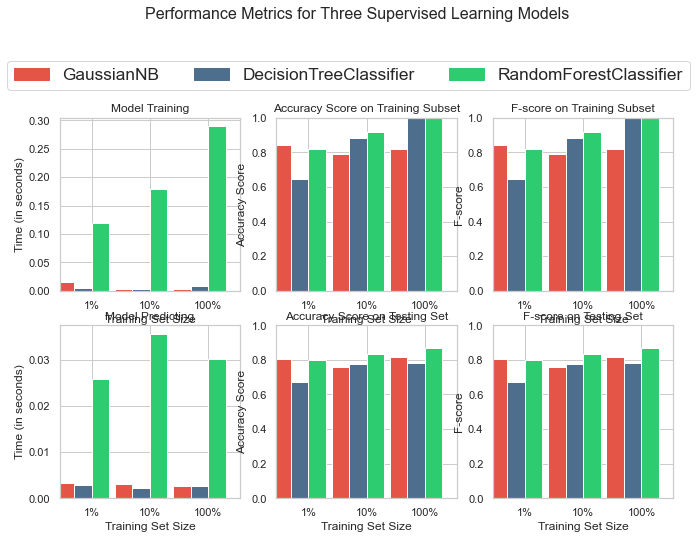

In [27]:
# Import any three supervised learning classification models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LogisticRegression

# Initialize the three models
clf_A = GaussianNB()
clf_B = DecisionTreeClassifier(max_depth=None, random_state=None)
clf_C = RandomForestClassifier(max_depth=None, random_state=None)


# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(len(y_train)*10/100)
samples_1 = int(len(y_train)*1/100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict_evaluate(clf, samples, X_train, y_train, X_test, y_test)

#print(results)

# Run metrics visualization for the three supervised learning models chosen
vs.visualize_classification_performance(results)

We can see RandomForest takes the longest to train, but ut also performs better than GuassianNB and Decision Tree

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict the quality of wines.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the wines dataset.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')
[0.07508818 0.12230451 0.08456165 0.08018291 0.07391153 0.06648886
 0.08624085 0.09563691 0.0693549  0.11815389 0.1280758 ]


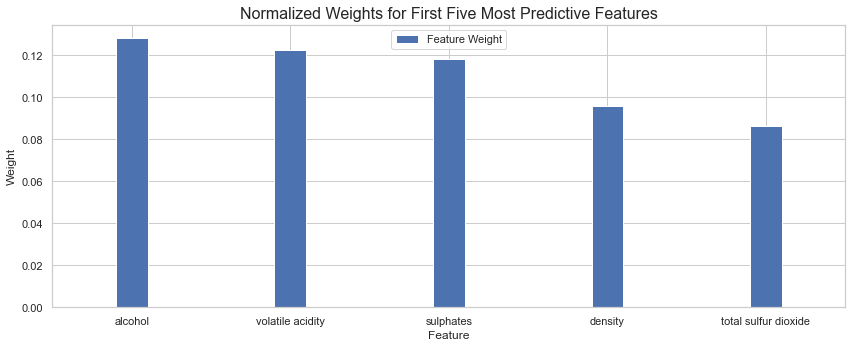

In [28]:
# Import a supervised learning model that has 'feature_importances_'
model = RandomForestClassifier(max_depth=None, random_state=None)

# Train the supervised model on the training set using .fit(X_train, y_train)
model = model.fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

print(X_train.columns)
print(importances)

# Plot
vs.feature_plot(importances, X_train, y_train)

## Hyperparameter tuning using GridSearchCV:

In [29]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = RandomForestClassifier(max_depth=None, random_state=None)

# Create the parameters or base_estimators list you wish to tune, using a dictionary if needed.
# Example: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}

"""
n_estimators: Number of trees in the forest
max_features: The number of features to consider when looking for the best split
max_depth: The maximum depth of the tree
"""
parameters = {'n_estimators': [10, 20, 30], 'max_features':[3,4,5, None], 'max_depth': [5,6,7, None]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5, average="micro")

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5, average="micro")))
print("\nOptimized Model\n------")
print(best_clf)
print("\nFinal accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5,  average="micro")))

Unoptimized model
------
Accuracy score on testing data: 0.8812
F-score on testing data: 0.8812

Optimized Model
------
RandomForestClassifier(max_features=None, n_estimators=20)

Final accuracy score on the testing data: 0.8750
Final F-score on the testing data: 0.8750


## Finally, you can test out your model by giving it a bunch of inputs:

In [30]:
"""Give inputs in this order: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide,
total sulfur dioxide, density, pH, sulphates, alcohol

"""
wine_data = [[8, 0.2, 0.16, 1.8, 0.065, 3, 16, 0.9962, 3.42, 0.92, 9.5],
            [8, 0, 0.16, 1.8, 0.065, 3, 16, 0.9962, 3.42, 0.92, 1 ],
            [7.4, 2, 0.00, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 0.6]]
               
# Show predictions
for i, quality in enumerate(best_clf.predict(wine_data)):
    print("Predicted quality for Wine {} is: {}".format(i+1, quality))

Predicted quality for Wine 1 is: 1
Predicted quality for Wine 2 is: 1
Predicted quality for Wine 3 is: 1
